In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd
import numpy as np

In [3]:
cd drive/MyDrive/Final_Project_Fall2023/

/content/drive/MyDrive/Final_Project_Fall2023


In [4]:

!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 9.1 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, TimeDistributed, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow_addons.seq2seq import AttentionWrapper, BahdanauAttention
from nltk.translate.bleu_score import corpus_bleu

/Users/raghavendrachitroju/Desktop/Fall 2023/FInal_Project_Fall_2023/venv/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/raghavendrachitroju/Desktop/Fall 2023/FInal_Project_Fall_2023/venv/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some thi

In [12]:
# Read your data
df = pd.read_csv('eng_french.csv', encoding='utf-8')

# Replace non-breaking spaces with regular spaces
df.replace('\u202F', ' ', regex=True, inplace=True)

df.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


### Data Pre Processing

### MOdel Building (Seq2Seq)

In [13]:
# Load and preprocess data
def load_and_preprocess_data(df):
    df = pd.read_csv(file_path)
    english_sentences = df['English words/sentences'].astype(str).tolist()
    french_sentences = df['French words/sentences'].astype(str).tolist()

    # Define maximum sentence length
    max_len = 20

    # Tokenize and pad sentences
    eng_tokenizer = Tokenizer()
    eng_tokenizer.fit_on_texts(english_sentences)
    X = pad_sequences(eng_tokenizer.texts_to_sequences(english_sentences), maxlen=max_len, padding='post')

    fr_tokenizer = Tokenizer()
    fr_tokenizer.fit_on_texts(french_sentences)
    y = pad_sequences(fr_tokenizer.texts_to_sequences(french_sentences), maxlen=max_len, padding='post')

    return train_test_split(X, y, test_size=0.2), eng_tokenizer, fr_tokenizer, max_len


### Train the Model

In [14]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Attention
from tensorflow.keras.models import Model
import numpy as np

def create_model(src_vocab_size, dest_vocab_size, src_timesteps, dest_timesteps, units, src_embedding_matrix, dest_embedding_matrix):
    # Encoder
    encoder_inputs = Input(shape=(src_timesteps,))
    encoder_embedding = Embedding(src_vocab_size, units, weights=[src_embedding_matrix], mask_zero=True, trainable=False)(encoder_inputs)
    encoder_lstm = LSTM(units, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

    # Decoder
    decoder_inputs = Input(shape=(dest_timesteps,))
    decoder_embedding = Embedding(dest_vocab_size, units, weights=[dest_embedding_matrix], mask_zero=True, trainable=False)(decoder_inputs)
    decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

    # Attention layer
    attention_layer = Attention()
    attention_result = attention_layer([decoder_outputs, encoder_outputs])

    # Concatenating the attention output and decoder LSTM output
    decoder_concat_input = Concatenate(axis=-1)([decoder_outputs, attention_result])

    # Dense layer
    dense = Dense(dest_vocab_size, activation='softmax')
    decoder_dense_output = dense(decoder_concat_input)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_dense_output)
    return model


In [15]:
def evaluate_model(model, X_test, y_test, tokenizer_fr, max_len):
    actual, predicted = [], []
    for i in range(len(X_test)):
        # Prepare the input for prediction
        input_seq = X_test[i].reshape(1, max_len)
        target_seq = y_test[i].reshape(1, max_len)

        # Predict the translation
        yhat = model.predict([input_seq, target_seq])
        yhat = np.argmax(yhat, axis=-1)[0]

        # Convert integer sequences to words
        actual_word_list = [tokenizer_fr.index_word[word] for word in y_test[i] if word != 0]
        predicted_word_list = [tokenizer_fr.index_word[word] for word in yhat if word != 0]

        # Append to the lists
        actual.append([actual_word_list])
        predicted.append(predicted_word_list)

    # Calculate BLEU score
    return corpus_bleu(actual, predicted)

In [16]:
# File path to your CSV dataset
file_path = 'eng_french.csv'

# Load and preprocess data
(X_train, X_test, y_train, y_test), tokenizer_eng, tokenizer_fr, max_len = load_and_preprocess_data(file_path)


In [15]:
# Model parameters
src_vocab_size = len(tokenizer_eng.word_index) + 1
dest_vocab_size = len(tokenizer_fr.word_index) + 1


def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def create_embedding_matrix(tokenizer, embeddings_index, embedding_dim):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Load GloVe embeddings
glove_file = 'glove.6B/glove.6B.200d.txt'  # Change this to the path of your GloVe file
embeddings_index = load_glove_embeddings(glove_file)

# Assuming you have your tokenizer_eng (English) and tokenizer_fr (French)
embedding_dim = 200  # Or the dimension of your GloVe embeddings
src_embedding_matrix = create_embedding_matrix(tokenizer_eng, embeddings_index, embedding_dim)
dest_embedding_matrix = create_embedding_matrix(tokenizer_fr, embeddings_index, embedding_dim)


# Create and compile the model with GloVe embeddings
units = 200
model = create_model(src_vocab_size, dest_vocab_size, max_len, max_len, units, src_embedding_matrix, dest_embedding_matrix)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Train the model
es = EarlyStopping(monitor='val_loss', patience=3)
lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
history = model.fit([X_train, y_train], y_train, epochs=15, batch_size=512, validation_data=([X_test, y_test], y_test), callbacks=[es, lr])

# Save the model
model.save('english_to_french_translation_model_with_attention.h5')


Epoch 1/15
275/275 [==============================] - 97s 328ms/step - loss: 4.8056 - val_loss: 3.1600 - lr: 0.0010
Epoch 2/15
275/275 [==============================] - 88s 319ms/step - loss: 2.7440 - val_loss: 2.4876 - lr: 9.0000e-04
Epoch 3/15
275/275 [==============================] - 88s 318ms/step - loss: 2.3287 - val_loss: 2.2275 - lr: 8.1000e-04
Epoch 4/15
275/275 [==============================] - 87s 318ms/step - loss: 2.1259 - val_loss: 2.0755 - lr: 7.2900e-04
Epoch 5/15
275/275 [==============================] - 87s 318ms/step - loss: 1.9955 - val_loss: 1.9714 - lr: 6.5610e-04
Epoch 6/15
275/275 [==============================] - 87s 318ms/step - loss: 1.9015 - val_loss: 1.8956 - lr: 5.9049e-04
Epoch 7/15
275/275 [==============================] - 87s 318ms/step - loss: 1.8281 - val_loss: 1.8320 - lr: 5.3144e-04
Epoch 8/15
275/275 [==============================] - 87s 318ms/step - loss: 1.7700 - val_loss: 1.7829 - lr: 4.7830e-04
Epoch 9/15
275/275 [========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
BLEU score: 0.16118887594975437


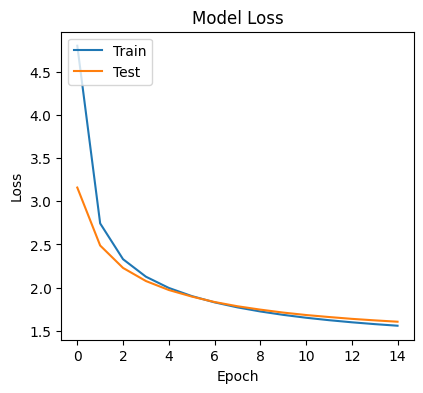

In [16]:
# Evaluate the model
bleu_score = evaluate_model(model, X_test, y_test, tokenizer_fr, max_len)
print(f'BLEU score: {bleu_score}')

# Plot training & validation loss values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=70f199cd73625976ee76127200faa1fb9ff35a87993806d13daea83a4d108702
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [18]:
from rouge_score import rouge_scorer

def evaluate_model_rouge(model, X_test, y_test, tokenizer_fr, max_len):
    actual, predicted = [], []
    for i in range(len(X_test)):
        # Prepare the input for prediction
        input_seq = X_test[i].reshape(1, max_len)
        target_seq = y_test[i].reshape(1, max_len)

        # Predict the translation
        yhat = model.predict([input_seq, target_seq])
        yhat = np.argmax(yhat, axis=-1)[0]

        # Convert integer sequences to words
        actual_word_list = [tokenizer_fr.index_word[word] for word in y_test[i] if word != 0]
        predicted_word_list = [tokenizer_fr.index_word[word] for word in yhat if word != 0]

        # Append to the lists
        actual.append(' '.join(actual_word_list))
        predicted.append(' '.join(predicted_word_list))

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for ref, hyp in zip(actual, predicted):
        scores = scorer.score(ref, hyp)
        rouge_scores['rouge1'].append(scores['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(scores['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(scores['rougeL'].fmeasure)

    avg_rouge_scores = {key: np.mean(values) for key, values in rouge_scores.items()}
    return avg_rouge_scores

# Example usage of the evaluate_model_rouge function
rouge_scores = evaluate_model_rouge(model, X_test, y_test, tokenizer_fr, max_len)
print(f"ROUGE scores: {rouge_scores}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
ROUGE scores: {'rouge1': 0.39756081457626047, 'rouge2': 0.29975323476028953, 'rougeL': 0.3963194898906168}
